# 3D plot of a detector from a '.yml' file
This is a quick and easy sanity check for after converting a file from pyFAI coordinates.

In [27]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def hexrd_rotation_matrix():
    """ The rotation order is X -> Y -> Z.
    All rotations are right-handed.
    The heXRD lab coordinates map to the pyFAI coordinates as follows:
    Z = -X_3
    Y = X_1
    X = X_2
    """
    cosrotx = np.cos(rotation[0])
    sinrotx = np.sin(rotation[0])
    cosroty = np.cos(rotation[1])
    sinroty = np.sin(rotation[1])
    cosrotz = np.cos(rotation[2])
    sinrotz = np.sin(rotation[2])

    rotz = np.array([[cosrotz, -sinrotz, 0],
                     [sinrotz, cosrotz, 0],
                     [0, 0, 1]])

    roty = np.array([[cosroty, 0, sinroty],
                     [0, 1, 0],
                     [-sinroty, 0, cosroty]])

    rotx = np.array([[1, 0, 0],
                     [0, cosrotx, -sinrotx],
                     [0, sinrotx, cosrotx]])

    rotation_matrix = np.dot(np.dot(rotz, roty), rotx)
    # order is Z, Y, X because matrices
    return rotation_matrix

In [29]:
yml_name = 'Configuration_test'
path = '../'
which_detector = 0

In [30]:
with open(path + yml_name + ".yml", 'r') as read_file:
    data = yaml.load(read_file, Loader=yaml.FullLoader)
    detectors = list(data['detectors'].keys())
    detector = detectors[which_detector]
    read_file.close()

rotation = data['detectors'][detector]['transform']['tilt']
location = data['detectors'][detector]['transform']['translation']
columns = data['detectors'][detector]['pixels']['columns']
rows = data['detectors'][detector]['pixels']['rows']
pixel_size = data['detectors'][detector]['pixels']['size']
energy = data['beam']['energy']
rotation_matrix_hexrd = hexrd_rotation_matrix()

In [31]:
id1, id2 = np.arange(-columns/2, columns/2, 1)*pixel_size[0]/1000, np.arange(-rows/2, rows/2, 1)*pixel_size[1]/1000
p1_pixel, p2_pixel = np.meshgrid(id2, id1)
p3_pixel = None

size = p1_pixel.size

p2 = p2_pixel.ravel() ## axis 2: horizontal and perpendicular to beam
p1 = p1_pixel.ravel() ## axis 1: vertical and perpendicular to beam
p3 = np.zeros(size)

## Pixel position in the detector frame centered at the sample position
## To get the same orientation as pyFAI for the rotation (axis1, axis2, axis3) triad (vertical axis, horizontal axis, along X-ray beam)
coord_det = np.vstack((p1, p2, p3))

## Pixel position in the sample frame
coord_detector = np.dot(rotation_matrix_hexrd, coord_det)

array = np.ones_like(p1)
location_array = np.vstack((array*location[0], array*location[1], array*location[2]))

COORD_SAMPLE = coord_detector + location_array/1000

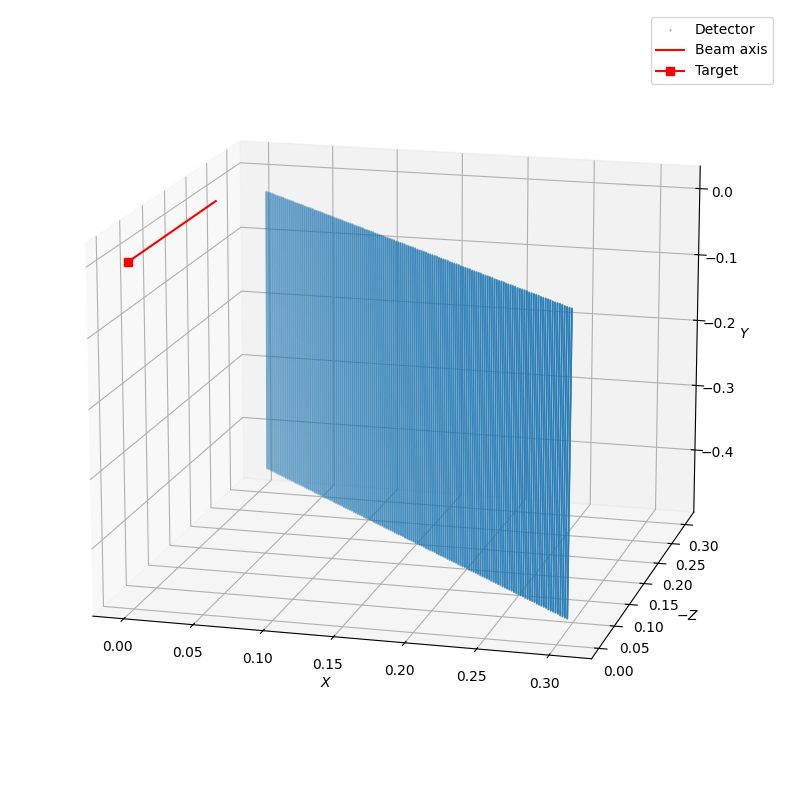

In [36]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(COORD_SAMPLE[0, ::100], -COORD_SAMPLE[2, ::100], COORD_SAMPLE[1, ::100], s=0.1, label='Detector')
ax.plot3D([0, 0], [0, 0.2], [0, 0], 'red', label='Beam axis')
ax.plot(0, 0, 0, marker='s', c='red', label='Target')
ax.view_init(elev=15, azim=-75)
ax.set_xlabel('$X$')
ax.set_ylabel('$-Z$')
ax.set_zlabel('$Y$')
plt.legend()
plt.show()